In [1]:
# Run the command below if smote-variants is not installed
#pip install smote-variants

In [2]:
import pandas as pd
import numpy as np
import smote_variants as sv
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# Loading the dataset in a pandas dataframe
df = pd.read_csv('train_data.csv')
print(df.shape)

(20000, 6)


In [4]:
# Separating the target variable y from the dataframe
y = df['failed']
y = y.to_numpy()
print(y.shape)

(20000,)


In [5]:
# Separating the data varaible X from the dataframe
X = df.loc[:, df.columns != 'failed']
X = X.loc[:, X.columns != 'job_id']
X.head()

,memory_GB,network_log10_MBps,local_IO_log10_MBps,NFS_IO_log10_MBps
0,44.3904,-1.0262,0.8033,-3.0000
1,31.5839,-1.4608,-0.6080,-2.9967
2,154.4610,-0.5508,-0.3637,-3.0000
3,71.8570,3.5701,-0.1281,2.3040
4,30.0370,3.3094,-0.9463,-3.0000


In [6]:
# Using robust scaler to scale the data 
rob_scaler = RobustScaler()

X['Memory'] = rob_scaler.fit_transform(X['memory_GB'].values.reshape(-1,1))
X['net'] = rob_scaler.fit_transform(X['network_log10_MBps'].values.reshape(-1,1))
X['local'] = rob_scaler.fit_transform(X['local_IO_log10_MBps'].values.reshape(-1,1))
X['nfs'] = rob_scaler.fit_transform(X['NFS_IO_log10_MBps'].values.reshape(-1,1))
X.drop(["memory_GB", "network_log10_MBps", "local_IO_log10_MBps", "NFS_IO_log10_MBps"], axis=1, inplace=True)
X.head()

,Memory,net,local,nfs
0,1.424964,-0.705519,1.046235,0.000000
1,0.796114,-0.846896,-0.278680,0.001179
2,6.829861,-0.550869,-0.049333,0.000000
3,2.773681,0.789675,0.171846,1.895453
4,0.720156,0.704868,-0.596273,0.000000


In [7]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

print("Before OverSampling count of Failed: {}".format(sum(y_train==1)))
print("Before OverSampling count of Not Failed: {} \n".format(sum(y_train==0)))

Before OverSampling count of Failed: 1400
Before OverSampling count of Not Failed: 15600 



In [8]:
# The dataset is heavily skewed i.e, the amount of negative examples is very low
# compared to positive examples
# We have used oversampling to solve this problem 

# Instantiating the SMOTE class
oversampler= sv.MSMOTE()

# Creating new training set
X_train_os, y_train_os = oversampler.sample(np.array(X_train), np.array(y_train))

# Shape after oversampling

print('After OverSampling, the shape of train_X: {}'.format(X_train_os.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_os.shape))

print("After OverSampling count of Failed: {}".format(sum(y_train_os==1)))
print("After OverSampling count of Not Failed: {} \n".format(sum(y_train_os==0)))

2021-06-29 21:00:05,080:INFO:MSMOTE: Running sampling via ('MSMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


After OverSampling, the shape of train_X: (31200, 4)
After OverSampling, the shape of train_y: (31200,) 

After OverSampling count of Failed: 15600
After OverSampling count of Not Failed: 15600 



In [9]:
# Function to calculate the balanced accuracy from the confusion matrix
def Balanced_Accuracy(mat):
    actual_pos = mat[0][0] + mat[0][1]
    actual_neg = mat[1][0] + mat[1][1]

    pos_cls_acc = mat[0][0] / actual_pos
    neg_cls_acc = mat[1][1] / actual_neg

    balanced_acc = (pos_cls_acc + neg_cls_acc) /2
    return balanced_acc


In [10]:
# Function to display the balanced accuracy and the confusion matrix 
def performance_measures_balanced(clf, y_pred, X_test, y_test):
    
    # Computing the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Balanced Accuracy: {Balanced_Accuracy(conf_matrix)}")
    
    # Plotting the confusion matrix 
    plot_confusion_matrix(clf, X_test, y_test, cmap='Blues')

In [11]:
# Function to train and test on different models
def train_and_test(X_train, X_test, y_train, y_test, classifier):
    
    if classifier == 'decision_tree':
        clf = DecisionTreeClassifier(random_state=42)
    elif classifier == 'random_forest':
        clf = RandomForestClassifier(random_state=42)
    elif classifier == 'gradient_boosting':
        clf = GradientBoostingClassifier(random_state=42)
    elif classifier == 'logistic_regression':
        clf = LogisticRegression(random_state=42)
    elif classifier == 'knn':
        clf = KNeighborsClassifier()
    elif classifier == 'mlp':
        clf = MLPClassifier(random_state=42, max_iter=200, learning_rate_init=1e-2)
    elif classifier == 'ada':
        clf = AdaBoostClassifier(random_state=42, n_estimators=10)
    elif classifier == 'ensemble':
        # Ensembling different models to get a better accuracy 
        clf1 = AdaBoostClassifier(random_state=42, n_estimators=50)
        clf2 = MLPClassifier(random_state=42, max_iter=200, learning_rate_init=0.01, alpha = 0.01)
        clf3 = KNeighborsClassifier()
        clf = VotingClassifier(estimators=[('mlp', clf1), ('rf', clf2), ('lr', clf3)], voting='hard')

    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)
    
    return clf, y_pred

Balanced Accuracy: 0.7656239033758478


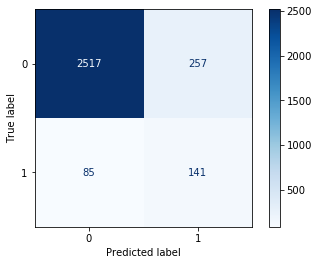

In [12]:
# Training the ensembled model using the oversampled dataset
eclf, y_pred = train_and_test(X_train_os, X_test, y_train_os, y_test, classifier='ensemble')
performance_measures_balanced(eclf, y_pred, X_test, y_test)

In [13]:
# Reading the cross-validation set into a pandas dataframe
unlabeled_test_set = pd.read_csv("test_data_unlabeled.csv")
unlabeled_test_set.head()

,job_id,memory_GB,network_log10_MBps,local_IO_log10_MBps,NFS_IO_log10_MBps
0,jobID845653,11.6819,1.9141,-0.5344,0.3944
1,jobID1649941,20.7483,-0.8377,0.3129,0.8652
2,jobID1228730,55.1166,-0.1672,-0.6554,-0.2249
3,jobID2366721,68.2202,-0.8236,1.2425,-3.0000
4,jobID1208568,20.7190,-2.0983,-0.6392,-3.0000


In [14]:
# Function to create the CSV containing predictions for evaluation 
def get_result_from_unlabeled(unlabeled, clf, n):
    # getting X_val
    X_val = unlabeled.loc[:, unlabeled.columns != 'job_id']
  
    #Scaling the values of X
    rob_scaler = RobustScaler()
    X_val['Memory'] = rob_scaler.fit_transform(X_val['memory_GB'].values.reshape(-1,1))
    X_val['net'] = rob_scaler.fit_transform(X_val['network_log10_MBps'].values.reshape(-1,1))
    X_val['local'] = rob_scaler.fit_transform(X_val['local_IO_log10_MBps'].values.reshape(-1,1))
    X_val['nfs'] = rob_scaler.fit_transform(X_val['NFS_IO_log10_MBps'].values.reshape(-1,1))
    X_val.drop(["memory_GB", "network_log10_MBps", "local_IO_log10_MBps", "NFS_IO_log10_MBps"], axis=1, inplace=True)
  
    # Predicting y
    y_pred_val = clf.predict(X_val)
  
    # Adding the predicted value to job_ID
    unlabeled['Failed'] = y_pred_val
    unlabeled.drop(["memory_GB", "network_log10_MBps", "local_IO_log10_MBps", "NFS_IO_log10_MBps"], axis=1, inplace=True)
  
    # To csv 
    unlabeled.to_csv(f"model_complete_test{n}.csv")




In [15]:
get_result_from_unlabeled(unlabeled_test_set, eclf, 6)